<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Kusal/Medium_term_scale(30min)_Dilated_CNN%2B_Stacked_LSTM_forecasted_power_merged_CEB_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Medium term scale(30 min) - Dilated CNN + Stacked LSTM**

# **SETUP**

In [21]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline
import plotly.express as px
import io


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

url1 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/S6%2010%20seconed%20data.csv' #S6 10 seconed data.csv
url2 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_1.csv' #AE59_1
url3 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_2.csv' #AE59_2
url4 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20June%2010%20sec%20data.csv' #V08 June 10 sec data.csv; does not contain current columns
url5 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv' #V13 June 10 sec data.csv
url6 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20July%2010%20sec%20data.csv' #V08 July 10 sec data.csv
url7 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20July%2010%20sec%20data.csv' #V13 July 10 sec data.csv
url8 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar.csv'  #Mannar dataset-10_min-wind_speed.csv
url9 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar%20full%20data.csv' #Mannar full data set.csv
url10 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/2018%20Scada%20Data%20of%20a%20Wind%20Turbine%20in%20Turkey.csv' #2018 Scada Data of a Wind Turbine in Turkey - 10 min resolution data
url11 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/CEB%20new%20updated(Only%20actual).csv' #CEB new dataset
url12 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/CEB_dataset_full_august_to_december.csv' #merged CEB dataset


In [22]:
df_original = pd.read_csv(url12)
df_original=pd.DataFrame(df_original)
#df_original

In [23]:
col_1=(df_original.columns)[0]
col_2=(df_original.columns)[1]
col_3=(df_original.columns)[2]
feature = 'Active Power'
forecast_pw = 'Forcasted Power'
df_original.rename(columns={col_1 :'Date & Time' , col_2 : feature , col_3 : forecast_pw},inplace=True)
#df_original

In [24]:
df_original=df_original.set_index('Date & Time')
#df_original

In [25]:
t_skip=3
df=df_original[t_skip::t_skip]
#df

In [26]:
df_new_1=df[[feature,forecast_pw]]

In [8]:
#df_new_1

In [27]:
date_output = pd.np.array((df.index.values))
#date_output

In [28]:
x=np.array(df_original[feature])
#x

In [29]:
def arraysum(x,t_skip):
  count=0
  sum=0
  l=[]
  for i in x:
    sum+=i
    count+=1
    if count==t_skip:
      l.append(sum/t_skip)
      count=0
      sum=0
  return l    

l=(arraysum(x,t_skip))
L=[]
for i,j in zip(date_output,l):
  L.append([i,j])
#L

In [30]:
df_new = pd.DataFrame(L, columns = ["Date & Time", "Active Power"])
#df_new

In [31]:
df_new[forecast_pw]=np.array(df_new_1[forecast_pw])
#df_new

In [32]:
df_temp=df_new.copy()

In [33]:
df=df_temp[:5000]

In [35]:
df=df.set_index('Date & Time')
df

,Active Power,Forcasted Power
Date & Time,,
8/1/2021 0:30,95.20,96.96
8/1/2021 1:00,90.93,89.47
8/1/2021 1:30,95.99,92.59
8/1/2021 2:00,95.90,92.91
8/1/2021 2:30,99.80,92.22
...,...,...
11/13/2021 11:20,87.56,89.24
11/13/2021 11:50,85.61,91.25
11/13/2021 12:20,86.55,90.47


**Data set plot**

In [36]:
fig = px.line(df,x=df.index, y='Active Power') 
fig.show()

# **Train, validation and test sets**
We separate our dataset into train, validation and test sets.

*   We train the model on the train set.
*   The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data.
*   After the model has finished training, we evaluate the model on the test set.

We will allocate last 5% of the data set as test data and 5% before test data as validation data.All the other data will be training data.





In [38]:
L=len(df)
valid_start=int(8*L/10)

train,valid=df[:valid_start],df[valid_start:]

#print(train.shape)
#print(valid.shape)


# print(train.describe())
# print(valid.describe())


In [ ]:
#date_time = pd.to_datetime(df_new['Date & Time'], format='%m/%d/%Y %H:%M')

# **Data preparation - training data**

I will get the input for each sample is a vector of previous **T lagged values**

**HORIZON=1** specifies that we have a forecasting horizon of 1 (t+1)

In [39]:
T = 6
HORIZON = 1

**Scale the time series within [0,1]**

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train=pd.DataFrame(train[feature])
train[feature] = scaler.fit_transform(train)

train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted[feature].shift(-1)
#train_shifted.head(10)


**Original vs scaled data:**

In [ ]:
'''df[df.index < valid_start+1][["Average Wind Speed (m/s)"]].rename(columns={"Average Wind Speed (m/s)":'original wind speed'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={"Average Wind Speed (m/s)":'scaled wind speed'}).plot.hist(bins=100, fontsize=12)
plt.show()'''

'df[df.index < valid_start+1][["Average Wind Speed (m/s)"]].rename(columns={"Average Wind Speed (m/s)":\'original wind speed\'}).plot.hist(bins=100, fontsize=12)\ntrain.rename(columns={"Average Wind Speed (m/s)":\'scaled wind speed\'}).plot.hist(bins=100, fontsize=12)\nplt.show()'

**Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example**

In [41]:
for t in range(1, T+1):
    train_shifted['active_power_t-'+str(T-t)] = train_shifted[feature].shift(T-t)
train_shifted = train_shifted.rename(columns={feature:'Original_active_power'})

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
#train_shifted.head(10)

**Train input and target arrays**

In [42]:
y_train = np.array(train_shifted["y_t+1"])
X_train=np.array(train_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])

In [ ]:
# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [43]:
print(y_train.shape)
print(X_train.shape)

(3994,)
(3994, 6)


# **Data preparation - validation set**

In [44]:
valid=pd.DataFrame(valid[feature])
valid_new=df[valid_start-T+1:] #Add T values beforehand to the validation set
valid_new=pd.DataFrame(valid_new[feature])
#valid_new.head(20)

In [45]:
valid_new[feature]=scaler.transform(valid_new)

#Validataion set preparation(Lagged values,create input and target arrays,reshape)]

valid_shifted = valid_new.copy() 
valid_shifted['y_t+1'] = valid_shifted[feature].shift(-1)
valid_shifted.head(10)

for t in range(1, T+1):
    valid_shifted['active_power_t-'+str(T-t)] = valid_shifted[feature].shift(T-t)
vali_shifted = valid_shifted.rename(columns={feature:'Original_active_power'})

valid_shifted = valid_shifted.dropna(how='any')

y_valid = np.array(valid_shifted["y_t+1"])
X_valid=np.array(valid_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [46]:
print(y_valid.shape)
print(X_valid.shape)

(999,)
(999, 6, 1)


# **Implement the  Neural Network**
We implement the convolutional neural network with 3 layers, 5 neurons in each layer, a kernel size of 3 in each layer, and dilation rates of 1, 2 and 4 for each successive layer.

LSTM layers following with flatten and dense layer

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.layers import LSTM
from keras.layers import Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [48]:
LATENT_DIM = 10
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 100

In [49]:
model=Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(LSTM(LATENT_DIM,return_sequences=True,input_shape=(T,1)))
model.add(LSTM(LATENT_DIM,return_sequences=True))
model.add(LSTM(LATENT_DIM))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

Use Adam optimizer and mean squared error as the loss function.

In [50]:
model.compile(optimizer='Adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 10)             30        
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 10)             210       
                                                                 
 conv1d_2 (Conv1D)           (None, 6, 10)             210       
                                                                 
 lstm (LSTM)                 (None, 6, 10)             840       
                                                                 
 lstm_1 (LSTM)               (None, 6, 10)             840       
                                                                 
 lstm_2 (LSTM)               (None, 10)                840       
                                                                 
 flatten (Flatten)           (None, 10)                0

In [51]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [52]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [53]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/100
125/125 [==============================] - 11s 21ms/step - loss: 0.1457 - val_loss: 0.0247
Epoch 2/100
125/125 [==============================] - 1s 11ms/step - loss: 0.0217 - val_loss: 0.0166
Epoch 3/100
125/125 [==============================] - 1s 11ms/step - loss: 0.0179 - val_loss: 0.0144
Epoch 4/100
125/125 [==============================] - 2s 16ms/step - loss: 0.0141 - val_loss: 0.0119
Epoch 5/100
125/125 [==============================] - 1s 11ms/step - loss: 0.0118 - val_loss: 0.0120
Epoch 6/100
125/125 [==============================] - 1s 11ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 7/100
125/125 [==============================] - 1s 11ms/step - loss: 0.0097 - val_loss: 0.0108
Epoch 8/100
125/125 [==============================] - 1s 11ms/step - loss: 0.0085 - val_loss: 0.0087
Epoch 9/100
125/125 [==============================] - 1s 11ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 10/100
125/125 [==============================] - 1s 11ms/step - loss: 0.00

Load the model with the smallest mape

In [54]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

plot training and validation losses

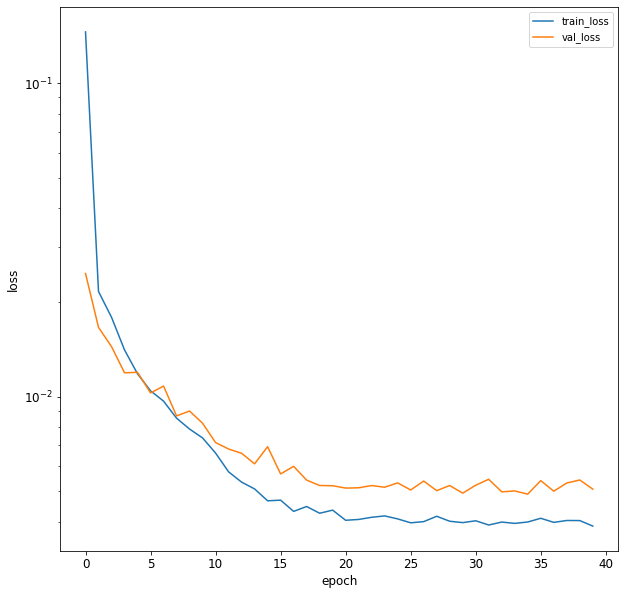

In [55]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

# **Evaluate the model** 

**Load test data set**

In [ ]:
# df_test = pd.read_csv(url11)
# df_test=pd.DataFrame(df_test)

In [ ]:
# df_test=df_test.drop(0)
# df_test=df_test.head(200)

In [56]:
test_set_1 = df_temp[5000:5200]  #10/1/2021 00:00 to 10/10/2021 23:50
test_set_2 = df_temp[10168:11608] #10/11/2021 00:00 to 10/20/2021 23:50
test_set_3 = df_temp[11608:13048] #10/21/2021 00:00 to 10/30/2021 23:50

dataset_index=1

if dataset_index==1:
  df_test = test_set_1
elif dataset_index==2:
  df_test = test_set_2
elif dataset_index==3:
  df_test = test_set_3

In [57]:
col_1=(df_test.columns)[0]
col_2=(df_test.columns)[1]
col_3=(df_test.columns)[2]
feature = 'Active Power'
feature_1 = 'Forecasted Power'
df_test.rename(columns={col_1 :'Date & Time' , col_2 : feature ,col_3 :feature_1},inplace=True)

In [58]:
df_test=df_test.set_index('Date & Time')
# df_test = df_test.apply(pd.to_numeric)
# df_test=df_test.div(1000)

In [ ]:
#df_test

In [59]:
count = (df_test[feature] == 0).sum()
count

0

**Preprocessing technique**

In [ ]:
#df_test[feature]=df_test[feature].replace(0,df_test[feature].median())
df_test[feature]=df_test[feature].replace(to_replace=0, method='ffill').values

In [60]:
scaler = MinMaxScaler()
test=pd.DataFrame(df_test[feature])
test[feature] = scaler.fit_transform(test)

In [61]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted[feature].shift(-1)

for t in range(1, T+1):
    test_shifted['active_power_t-'+str(T-t)] = test_shifted[feature].shift(T-t)
test_shifted = test_shifted.rename(columns={feature:'Original_active_power'})

forecasted_values=np.array(df_test[feature_1])
test_shifted[feature_1] = forecasted_values
#test_shifted

In [62]:
test_shifted = test_shifted.dropna(how='any')
y_test = np.array(test_shifted['y_t+1'])
X_test=np.array(test_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_test = X_test.reshape(X_test.shape[0], T, 1)
#X_test

In [63]:
print(y_test.shape)
print(X_test.shape)

(194,)
(194, 6, 1)


**Make predictions on test set**

In [64]:
predictions = model.predict(X_test)
predictions=pd.DataFrame(predictions)
#predictions

In [65]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['Date & Time'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='Date & Time', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df['prediction'] =predictions 

eval_df[feature_1]=np.array(test_shifted[feature_1])
#eval_df

In [66]:
eval_df[['prediction']]=scaler.inverse_transform(np.array(eval_df[['prediction']]))
eval_df[['actual']]=scaler.inverse_transform(np.array(eval_df[['actual']]))
eval_df

,Date & Time,h,prediction,actual,Forecasted Power
0,11/13/2021 16:20,t+1,92.77,95.44,97.17
1,11/13/2021 16:50,t+1,93.03,94.91,97.71
2,11/13/2021 17:20,t+1,92.16,95.09,96.57
3,11/13/2021 17:50,t+1,92.73,94.83,97.18
4,11/13/2021 18:20,t+1,92.24,95.07,96.62
...,...,...,...,...,...
189,11/17/2021 14:50,t+1,18.91,18.75,15.96
190,11/17/2021 15:20,t+1,18.51,12.53,16.03
191,11/17/2021 15:50,t+1,11.45,10.86,14.06
192,11/17/2021 16:20,t+1,10.59,7.72,8.82


**MAPE of our model**

In [67]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = eval_df['actual']
pred = eval_df['prediction']

mape(actual, pred)

29.3317035268369

**RMSE of our model**

In [68]:
def rmse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    x=np.mean((actual - pred)**2)
    return np.sqrt(x)

actual = eval_df['actual']
pred = eval_df['prediction']

rmse(actual, pred)

7.036368208424721

**MAPE of CEB model**

In [69]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = eval_df['actual']
pred = eval_df['Forecasted Power']

mape(actual, pred)

66.9078451498936

**RMSE of CEB model**

In [70]:
def rmse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    x=np.mean((actual - pred)**2)
    return np.sqrt(x)

actual = eval_df['actual']
pred = eval_df['Forecasted Power']

rmse(actual, pred)

10.162467231740102

In [71]:
fig1 = px.line(eval_df,x='Date & Time', y=['actual',feature_1,'prediction'],labels={ "value": 'Active power (MW)'},title="Dilated CNN+ Stacked LSTM model:Expected vs predicted power forecasting") 
fig1.update_layout(xaxis_title_font_size=16,yaxis_title_font_size=16,title_font_color='red',title_font_size=20)
fig1.show()

In [73]:
fig2 = px.line(eval_df,x='Date & Time', y=['actual','prediction'],labels={ "value": 'Active power (MW)'},title="Dilated CNN+ Stacked LSTM:Expected vs forecasted power") 
fig2.update_layout(xaxis_title_font_size=16,yaxis_title_font_size=16,title_font_color='red',title_font_size=20)
fig2.show()

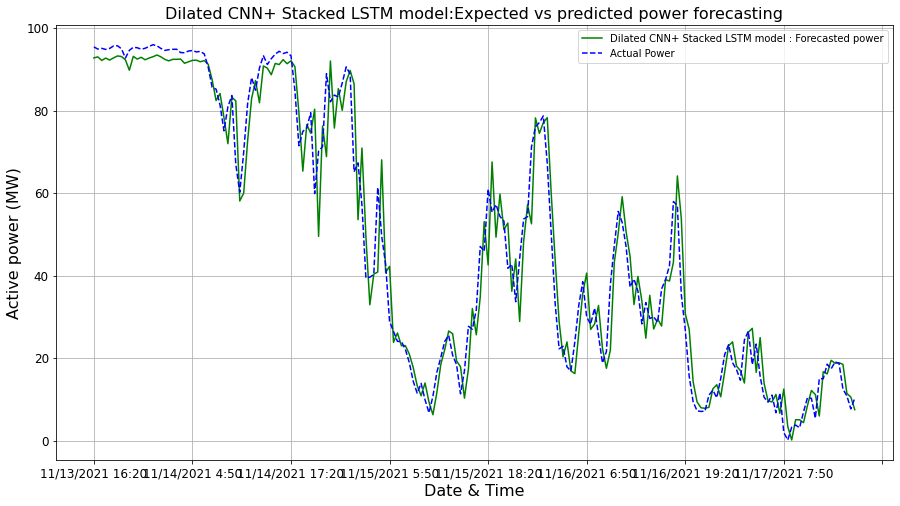

In [79]:
eval_df.plot(x='Date & Time', y=['prediction','actual'], style=['g','--b'],fontsize=12, figsize=(15, 8))
plt.title("Dilated CNN+ Stacked LSTM model:Expected vs predicted power forecasting",fontsize=16)
plt.xlabel('Date & Time', fontsize=16)
plt.ylabel('Active power (MW)', fontsize=16)
plt.grid()
plt.legend(['Dilated CNN+ Stacked LSTM model : Forecasted power', 'Actual Power'])
plt.savefig("Dilated CNN+ Stacked LSTM-results.pdf")
plt.savefig("Dilated CNN+ Stacked LSTM-results.png")
plt.show()

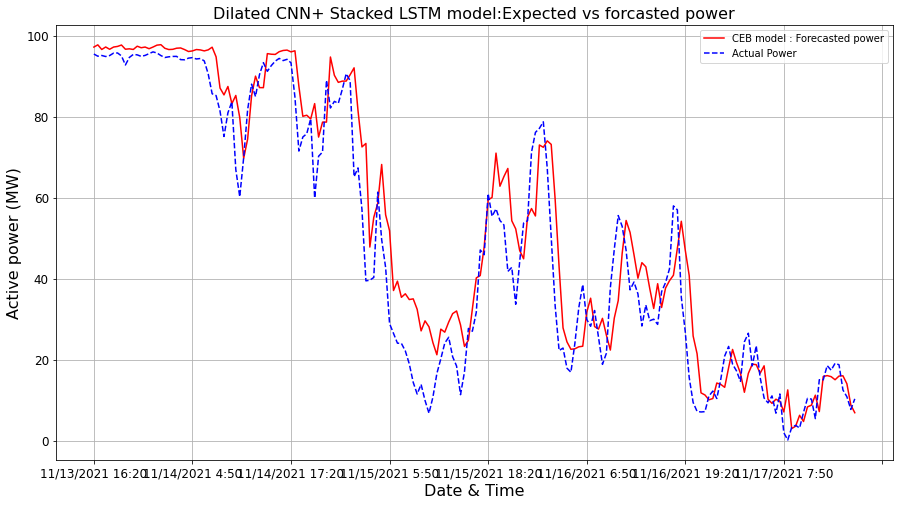

In [78]:
eval_df.plot(x='Date & Time', y=[feature_1, 'actual'], style=['r', '--b'],fontsize=12, figsize=(15, 8))
plt.title("Dilated CNN+ Stacked LSTM model:Expected vs forcasted power",fontsize=16)
plt.xlabel('Date & Time', fontsize=16)
plt.ylabel('Active power (MW)', fontsize=16)
plt.grid()
plt.legend(['CEB model : Forecasted power', 'Actual Power'])
plt.savefig("GRU-results-1.pdf")
plt.savefig("GRU-results-1.png")
plt.show()

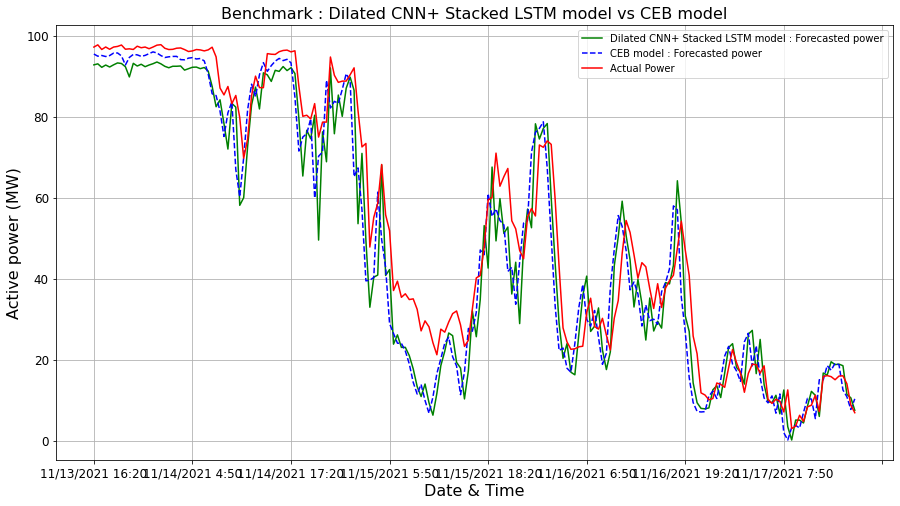

In [77]:
eval_df.plot(x='Date & Time', y=['prediction','actual',feature_1], style=['g','--b','r'],fontsize=12, figsize=(15, 8))
plt.title("Benchmark : Dilated CNN+ Stacked LSTM model vs CEB model",fontsize=16)
plt.xlabel('Date & Time', fontsize=16)
plt.ylabel('Active power (MW)', fontsize=16)
plt.grid()
plt.legend(['Dilated CNN+ Stacked LSTM model : Forecasted power','CEB model : Forecasted power', 'Actual Power'])
plt.savefig("benchmark.pdf")
plt.savefig("benchmark.png")
plt.show()

**Clean up model files**

In [80]:
for m in glob('model_*.h5'):
    os.remove(m)